In [1]:
# !pip install --user statsmodels

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

# 1. Observer et Nettoyer la Serie

In [3]:
data = pd.read_csv('airline_passengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  Thousands of Passengers
0  1949-01                      112
1  1949-02                      118
2  1949-03                      132
3  1949-04                      129
4  1949-05                      121

 Data Types:
Month                      object
Thousands of Passengers     int64
dtype: object


The data contains a particular month and number of passengers travelling in that month .The data type here is object (month) Let’s convert it into a Time series object and use the Month column as our index.

In [4]:
from datetime import datetime
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

You can see that now the data type is ‘datetime64[ns]’.Now let’s just make it into a series rather than a data frame ( this would make it easier for the blog explanation )

In [5]:
#convert to time series:
ts = data['Thousands of Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: Thousands of Passengers, dtype: int64

# 2. Transformer la série en série stationnaire et Dickey_Fuller

# STATIONARITY

This is a very important concept in Time Series Analysis. In order to apply a time series model, it is important for the Time series to be stationary; in other words all its statistical properties (mean,variance) remain constant over time. This is done basically because if you take a certain behavior over time, it is important that this behavior is same in the future in order for us to forecast the series. There are a lot of statistical theories to explore stationary series than non-stationary series. (Thus we can bring the fight to our home ground!)

In practice we can assume the series to be stationary if it has constant statistical properties over time and these properties can be:
- constant mean
- constant variance
- an auto co-variance that does not depend on time.

These details can be easily retrieved using stat commands in python.
The best way to understand you stationarity in a Time Series is by eye-balling the plot:

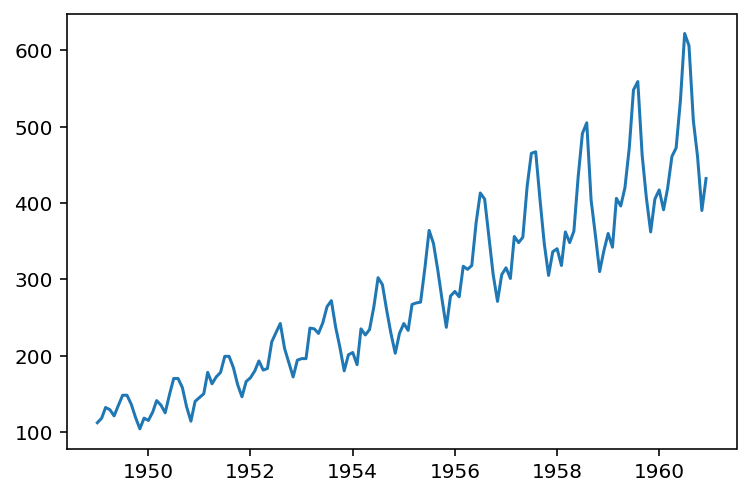

In [6]:
plt.plot(ts)

It’s clear from the plot that there is an overall increase in the trend,with some seasonality in it.

I have written a function for it as I will be using it quite often in this Time series explanation. But before we get to that,let me explain all the concepts in the function.

Plotting Rolling Statistics :The function will plot the moving mean or moving Standard Deviation. This is still visual method

NOTE: moving mean and moving standard deviation — At any instant ‘t’, we take the mean/std of the last year which in this case is 12 months)

Dickey-fuller Test :This is one of the statistical tests for checking stationarity. First we consider **the null hypothesis: the time series is non- stationary**. The result from the rest will contain the test statistic and critical value for different confidence levels. The idea is to have Test statistics less than critical value, in this case we can reject the null hypothesis and say that this Time series is indeed stationary.

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

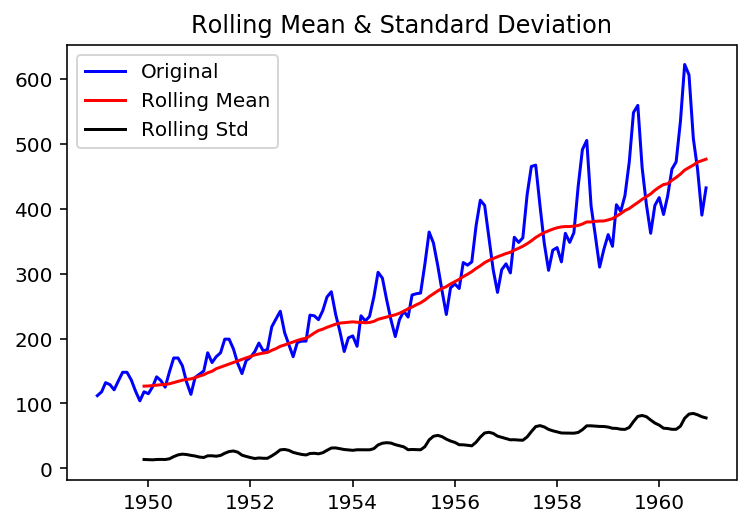

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
test_stationarity(ts)

With a p-value > 0.05, we can't reject the null hypotehsis. This data set is not stationary.

This is not stationary because :
- mean is increasing even though the std is small.
- Test stat is > critical value.
- Note: the signed values are compared and the absolute values.

# MAKING THE TIME SERIES STATIONARY

There are two major factors that make a time series non-stationary. They are:
- Trend: non-constant mean
- Seasonality: Variation at specific time-frames

The basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary. Then we can go ahead and apply statistical forecasting to the stationary series. And finally we can convert the forecasted values into original by applying the trend and seasonality constrains back to those that we previously separated.

Let’s start by working on the trend piece.

# Trend

The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend. These transformation can be log, sq-rt, cube root etc . Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation.

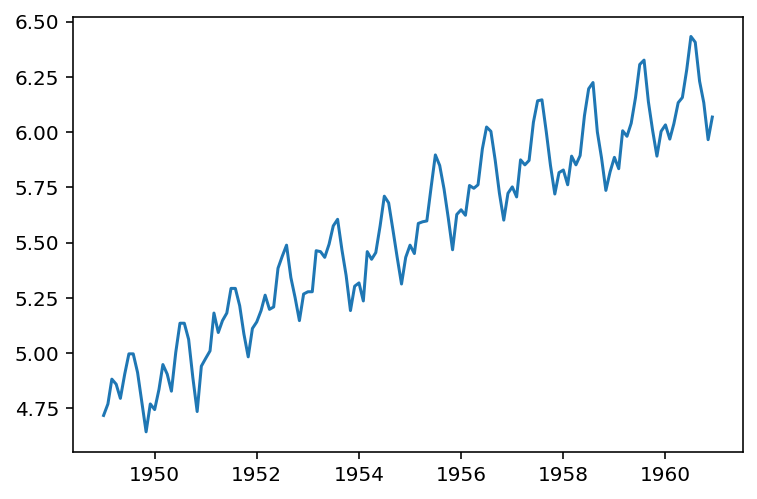

In [9]:
ts_log = np.log(ts)
plt.plot(ts_log)

There is some noise in realizing the forward trend here. There are some methods to model these trends and then remove them from the series. Some of the common ones are:
- Smoothing: using rolling/moving average
- Aggression: by taking the mean for a certain time period (year/month)

I will be using Smoothing here.

**Smoothing:**

In smoothing we usually take the past few instances (rolling estimates) We will discuss two methods under smoothing- Moving average and Exponentially weighted moving average.

*Moving average* 

First take x consecutive values and this depends on the frequency if it is 1 year we take 12 values. Lucky for us that Pandas has a function for rolling estimate


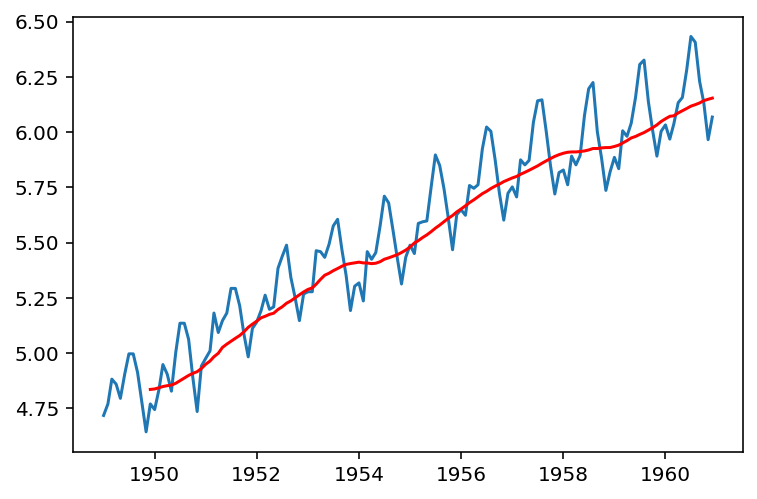

In [10]:
moving_average = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_average, color = 'red')

Now subtract the rolling mean from the original series.

In [11]:
ts_log_moving_avg_diff = ts_log - moving_average
ts_log_moving_avg_diff.head()

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: Thousands of Passengers, dtype: float64

In [12]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: Thousands of Passengers, dtype: float64

The reason there are null values is because we take the average of first 12 so 11 values are null. We can also see that in the visual representation. Thus it is dropped for further analysis. Now let’s parse it to the function to check for stationarity.

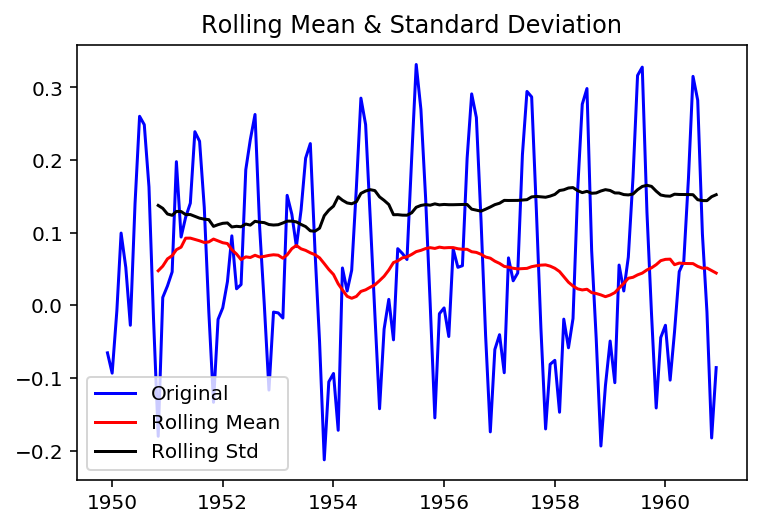

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [13]:
test_stationarity(ts_log_moving_avg_diff)

We notice two things:
- The rolling values are varying slightly but there is no specific trend.
- The test statistics is smaller than the 5 % critical values. That tells us that we are 95% confident that this series is stationary.

In this example we can easily take a time period (12 months for a year), but there are situations where the time period range is more complex like stock price etc. So we use the exponentially weighted moving average (there are other weighted moving averages but for starters, lets use this). The previous values are assigned with a decay factor. Pandas again comes to the rescue with some awesome functions for it, like:

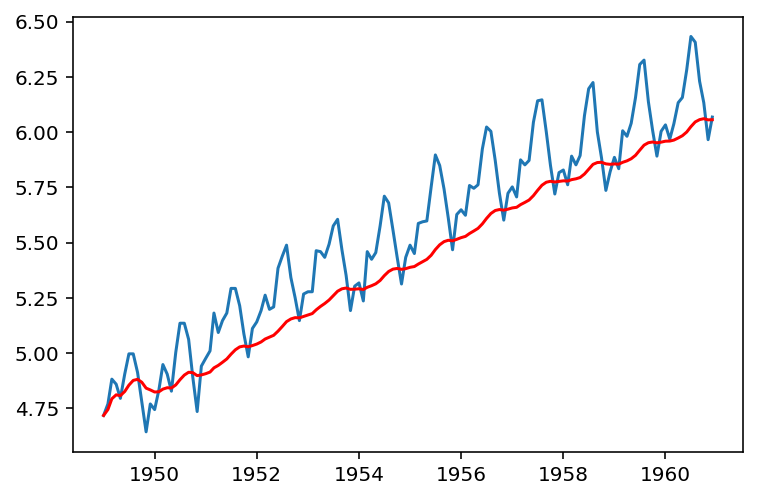

In [14]:
expwhighted_avg = pd.DataFrame.ewm(ts_log, halflife = 12).mean()
plt.plot(ts_log)
plt.plot(expwhighted_avg, color='red')

the parameter (halflife) is assumed 12, but it really depends on the domain. Let’s check stationarity now:

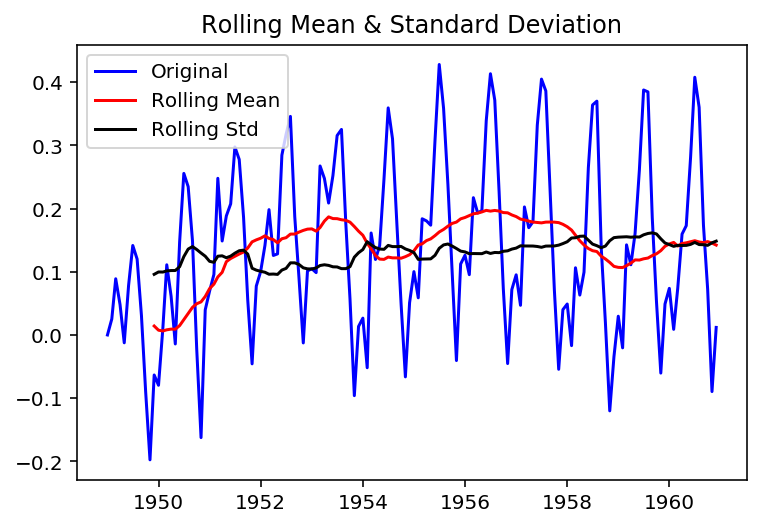

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
ts_log_ewma_diff = ts_log - expwhighted_avg
test_stationarity(ts_log_ewma_diff)

It is stationary because:
- Rolling values have less variations in mean and standard deviation in magnitude.
- the test statistic is smaller than 1% of the critical value. So we can say we are almost 99% confident that this is stationary.

## Seasonality (along with Trend)

Previously we saw just trend part of the time series, now we will see both trend and seasonality. Most Time series have trends along with seasonality. There are two common methods to remove trend and seasonality, they are:
- Differencing: by taking difference using time lag
- Decomposition: model both trend and seasonality, then remove them

*Differencing*:

Here we first take the difference of the value at a particular time with that of the previous time. Now let’s do it in Pandas.

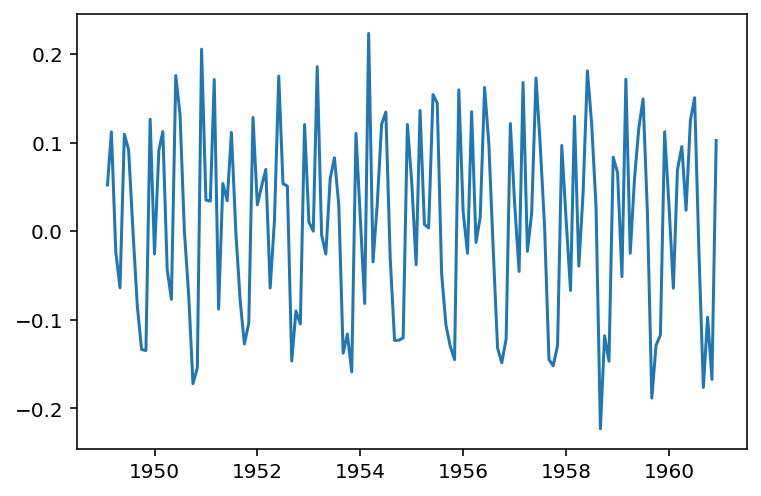

In [16]:
# Take first difference
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

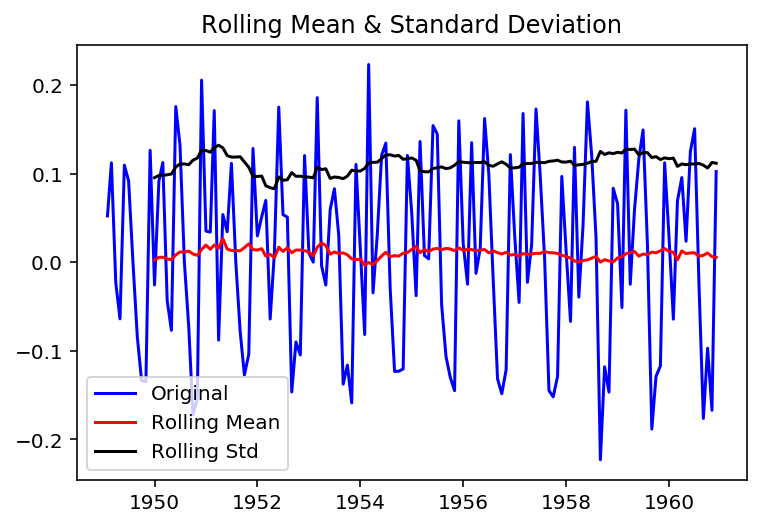

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [17]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

It is stationary because:
- the mean and std variations have small variations with time.
- test statistic is less than 10% of the critical values, so we can be 90 % confident that this is stationary.

*Decomposing*:

Here we model both the trend and the seasonality, then the remaining part of the time series is returned.

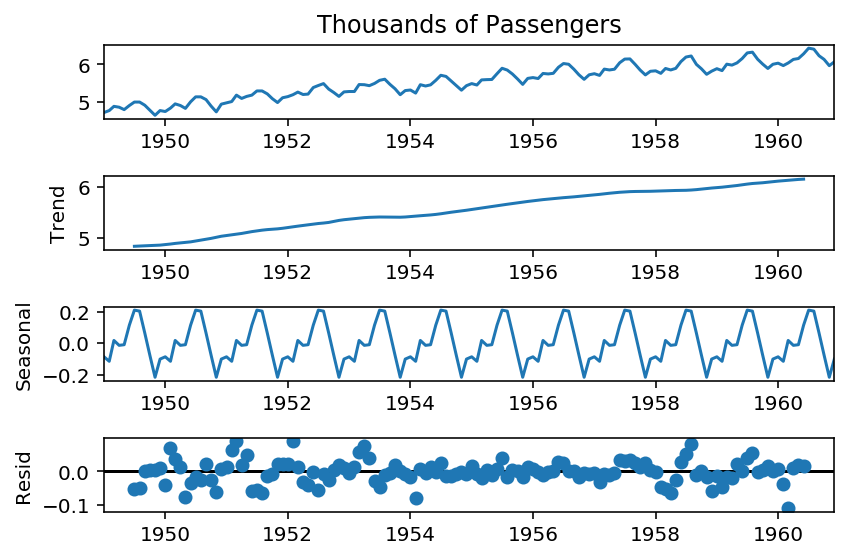

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_log)
result.plot()
plt.show()

Remove the trend and seasonality from the Time series and now we can use the residual values. Let’s check stationarity.

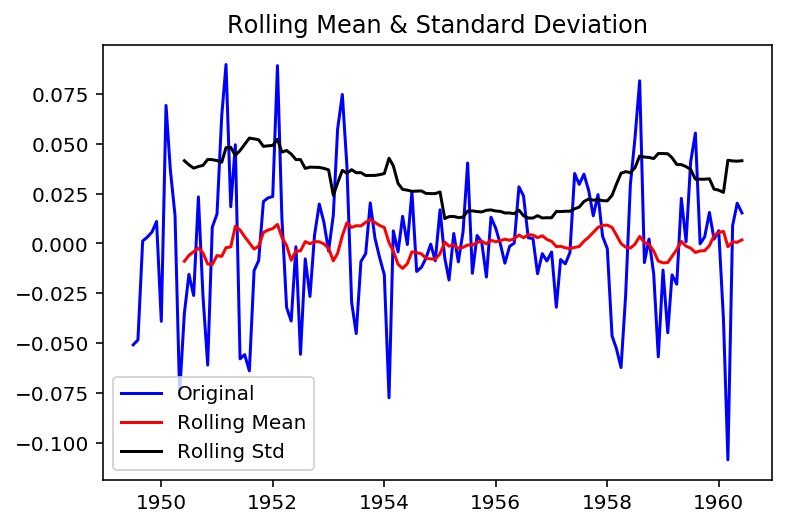

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [19]:
residual = result.resid
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [20]:
ts_log_decompose

Month
1949-07-01   -0.050884
1949-08-01   -0.048415
1949-09-01    0.001223
1949-10-01    0.003156
1949-11-01    0.005749
                ...   
1960-02-01   -0.038032
1960-03-01   -0.108624
1960-04-01    0.009006
1960-05-01    0.020213
1960-06-01    0.015348
Name: resid, Length: 132, dtype: float64

This is stationary because:
- test statistic is lower than 1% critical values.
- the mean and std variations have small variations with time.

# Forecasting a Time Series

Now that we have made the Time series stationary, let’s make models on the time series using differencing because it is easy to add the error , trend and seasonality back into predicted values.

We will use statistical modelling method called **ARIMA** to forecast the data where there are dependencies in the values.
**Auto Regressive Integrated Moving Average(ARIMA)** — It is like a liner regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model .

Let me explain these dependent parameters:
- p : This is the number of AR (Auto-Regressive) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).
- q : This is the number of MA (Moving-Average) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).
- d :This is the number of differences or the number of non-seasonal differences.

Now let’s check out on how we can figure out what value of p and q to use. We use two popular plotting techniques; they are:

- **Autocorrelation Function (ACF)**: It just measures the correlation between two consecutive (lagged version). example at lag 4, ACF will compare series at time instance t1…t2 with series at instance t1–4…t2–4
- **Partial Autocorrelation Function (PACF)**: is used to measure the degree of association between y(t) and y(t-p).


# 3. Etudier l'auto-corrélation en traçant l'ACF et la PACF enfin de fixer les ordres p et q d'un modèle ARMA ou ARIMA

# ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them.

C:\Users\utilisateur\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, "Fonction d'Autocorrelation Partielle")

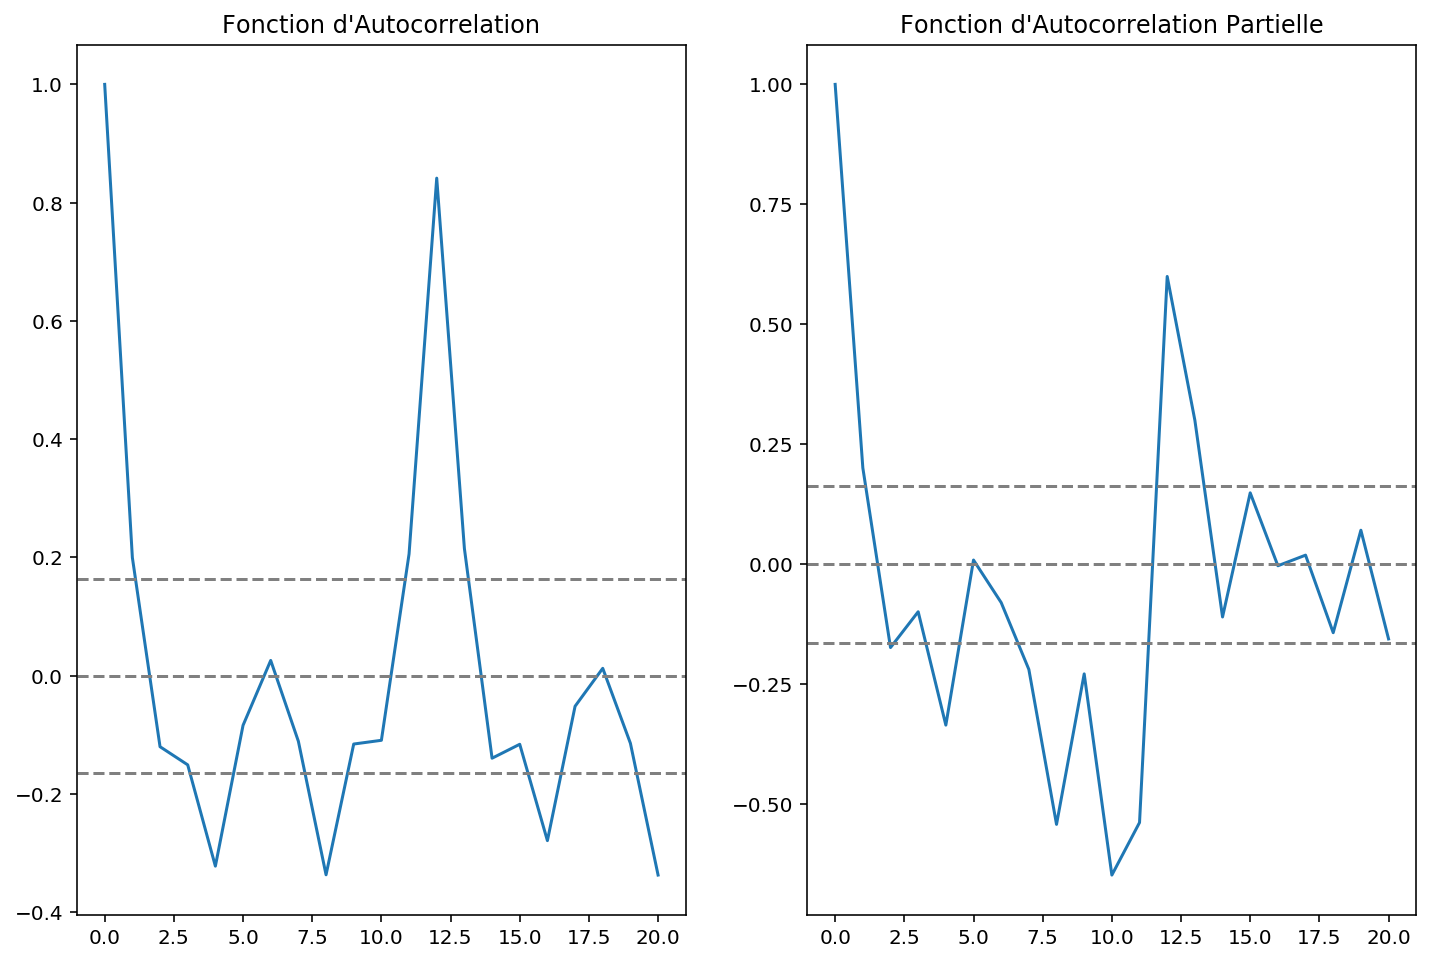

In [21]:
from statsmodels.tsa.arima_model import ARIMA
# ACF et PACF graphes:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags = 20) # ts_log_decompose
lag_pacf = pacf(ts_log_diff, nlags = 20, method = 'ols') # ts_log_decompose

# Plot ACF :
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Fonction d\'Autocorrelation')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Fonction d\'Autocorrelation Partielle')


The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values as:
- p: The first time where the PACF crosses the upper confidence interval, here its close to 2. hence p = 2.
- q: The first time where the ACF crosses the upper confidence interval, here its close to 2. hence p = 2.

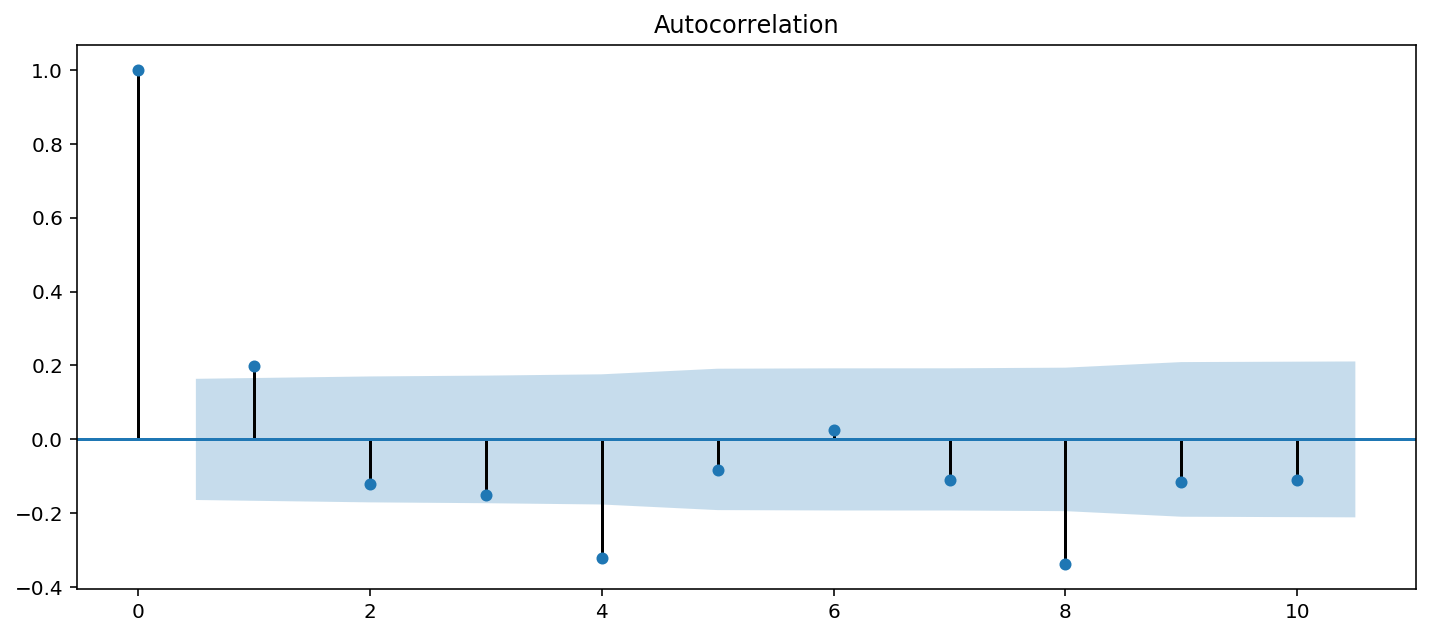

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(ts_log_diff, lags=10, ax=ax)
plt.show()

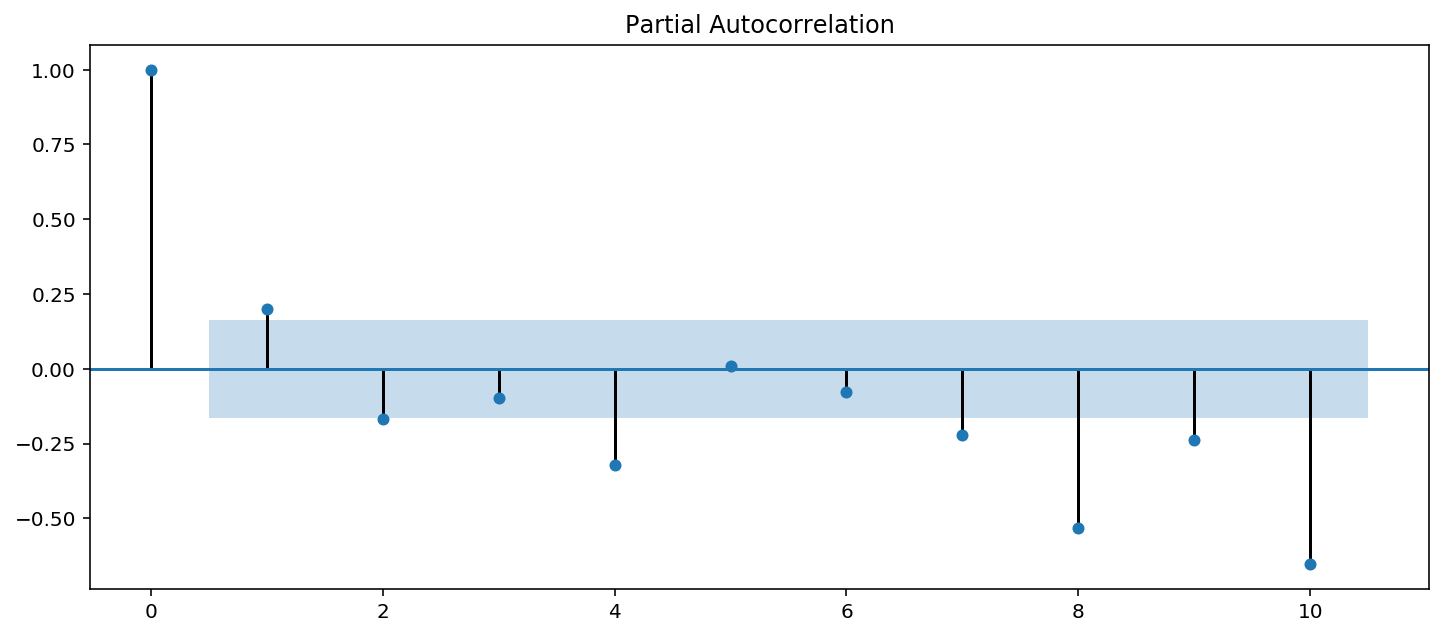

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(ts_log_diff, lags=10, ax=ax)
plt.show()

<img src="How_to_Read_PACF_ACF.jpg" style="width:400px;heigth:400px"/>

# 4. Splitter les données

Observations: 73
Training Observations: 38
Testing Observations: 35
Observations: 108
Training Observations: 73
Testing Observations: 35
Observations: 143
Training Observations: 108
Testing Observations: 35


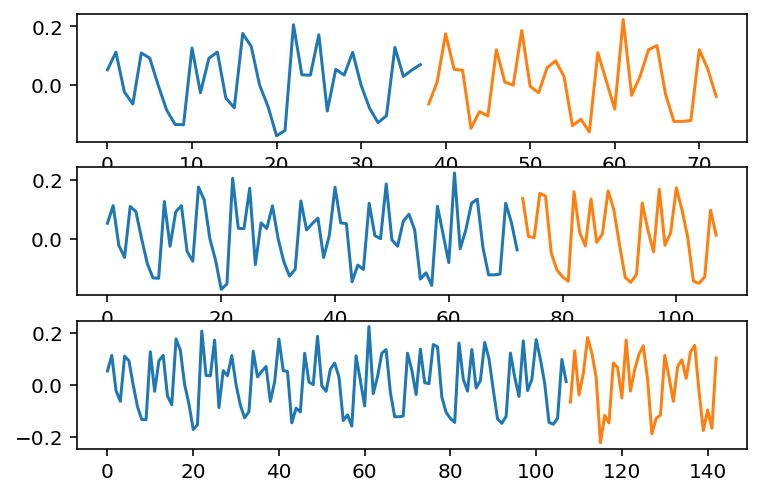

In [24]:
from sklearn.model_selection import TimeSeriesSplit

X = ts_log_diff.values
splits = TimeSeriesSplit(n_splits=3)
plt.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()

Observations: 132
Training Observations: 105
Testing Observations: 27


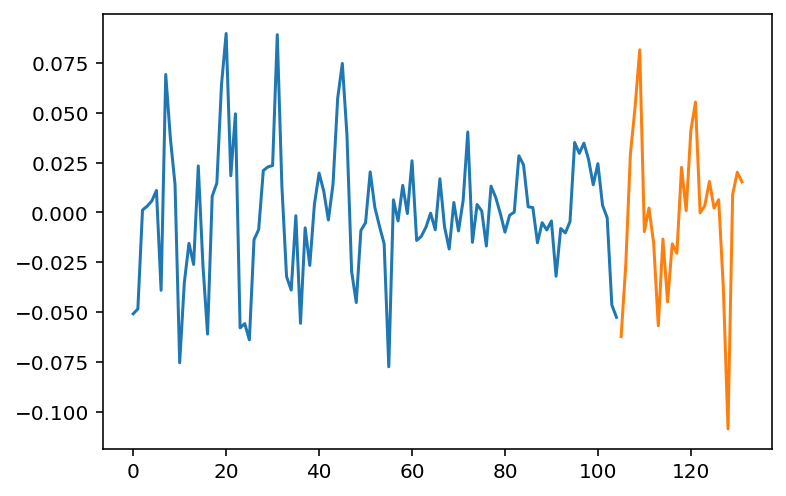

In [25]:
X = ts_log_decompose.values
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

# 5. Fitter le modèle, tester des variantes du modèle autour des valeurs p et q, les classer suivant une métrique

Let's Use Statsmodel's ARIMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

Now, using this make an ARIMA model and an ARMA model. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.
- The RSS is the sum of the square of the errors (difference between calculation and measurement, or estimated and real values)

In statistics, the residual sum of squares (RSS), also known as the sum of squared residuals (SSR) or the sum of squared estimate of errors (SSE), is the sum of the squares of residuals (deviations predicted from actual empirical values of data). It is a measure of the discrepancy between the data and an estimation model. A small RSS indicates a tight fit of the model to the data. It is used as an optimality criterion in parameter selection and model selection.

# Build ARIMA Model

In [26]:
# pip install pmdarima

In [27]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# df = pd.read_csv('airline_passengers.csv', names=['value'], header=0)
df = pd.DataFrame(ts_log_decompose)

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-538.354, BIC=-526.823, Time=0.296 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-518.961, BIC=-513.195, Time=0.103 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-540.128, BIC=-531.480, Time=0.232 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-536.887, BIC=-528.239, Time=0.211 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=-520.872, BIC=-517.989, Time=0.037 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-538.628, BIC=-527.097, Time=0.179 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-564.147, BIC=-549.733, Time=0.707 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-561.421, BIC=-544.124, Time=0.819 seconds
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-565.897, BIC=-548.600, Time=0.777 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-545.688, BIC=-531.

Modèle sur l'ensemble de train correspond à 80% du dataset

In [58]:
results_ARIMA.fittedvalues

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
                ...   
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
Length: 143, dtype: float64

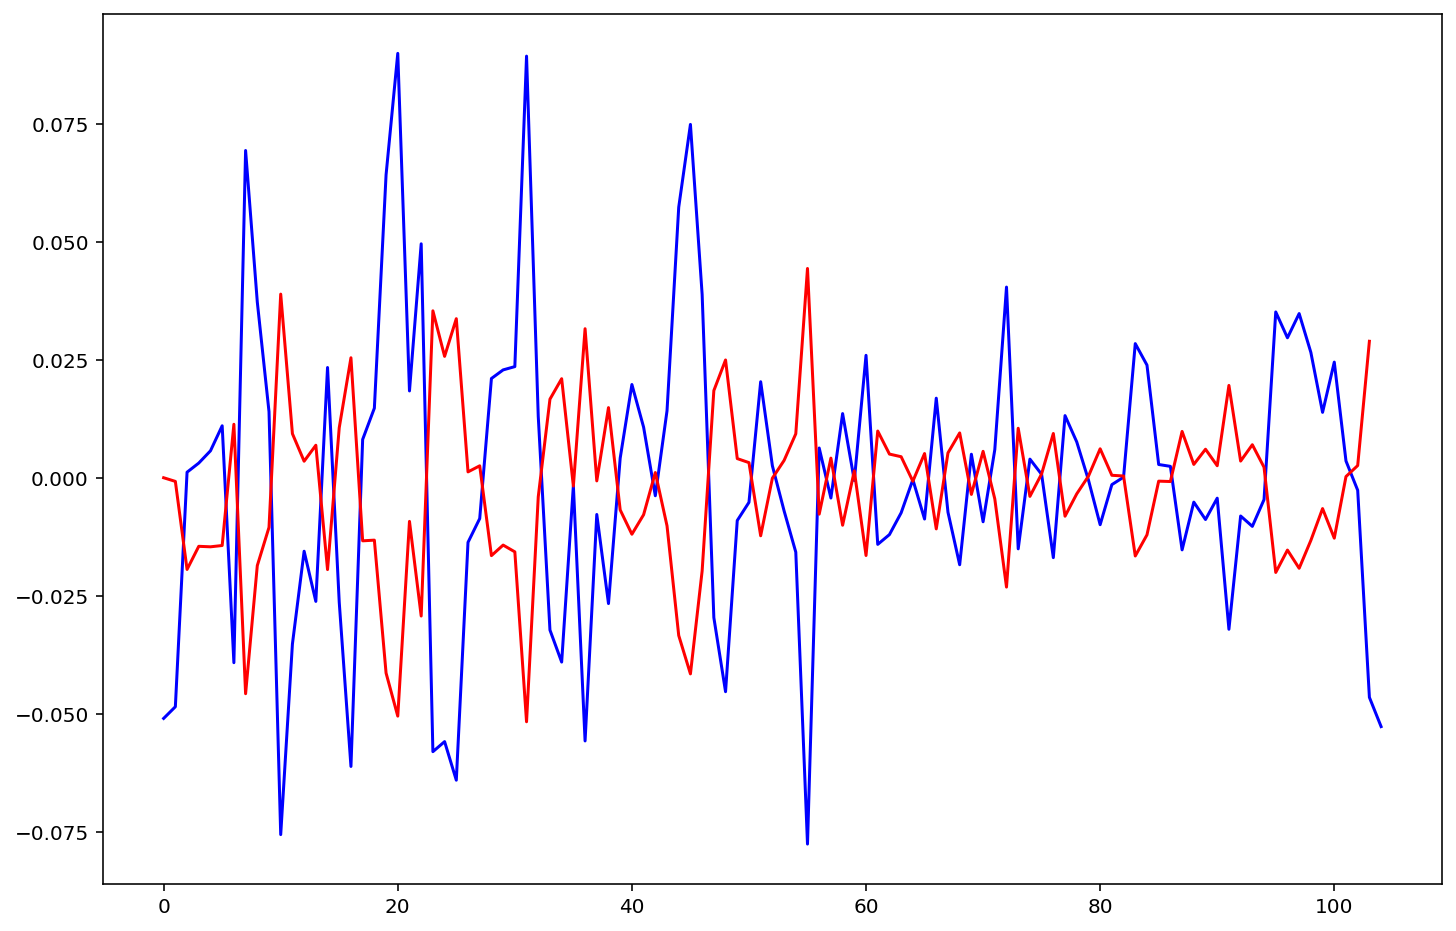

In [61]:
model = ARIMA(tuple(train), order=(2,1,2))
results_ARIMA_train = model.fit(disp=-1)
plt.figure(figsize=(12, 8))
plt.plot(train, color='blue')
preds = results_ARIMA_train.fittedvalues
plt.plot(preds, color='red')
plt.show()

In [29]:
results_ARIMA_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  104
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 217.636
Method:                       css-mle   S.D. of innovations              0.029
Date:                Wed, 01 Apr 2020   AIC                           -423.272
Time:                        12:40:50   BIC                           -407.406
Sample:                             1   HQIC                          -416.844
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.96e-05      0.000      0.305      0.760      -0.000       0.000
ar.L1.D.y     -0.1845      0.524     -0.352      0.725      -1.212       0.843
ar.L2.D.y      0.2838      0.220      1.293      0.196      -0.147       0.714
ma.L1.D.y     -0.4140      0.524     -0.791      0.429      -1.440       0.612
ma.L2.D.y     -0.5860      0.523     -1.120      0.263      -1.611       0.439
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5801           +0.0000j            1.5801            0.5000
AR.2            2.2302           +0.0000j            2.2302            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.7064           +0.0000j            1.7064            0.5000
-----------------------------------------------------------------------------
"""

Modèle ARIMA sur les données log et différenciées

C:\Users\utilisateur\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\utilisateur\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: nan')

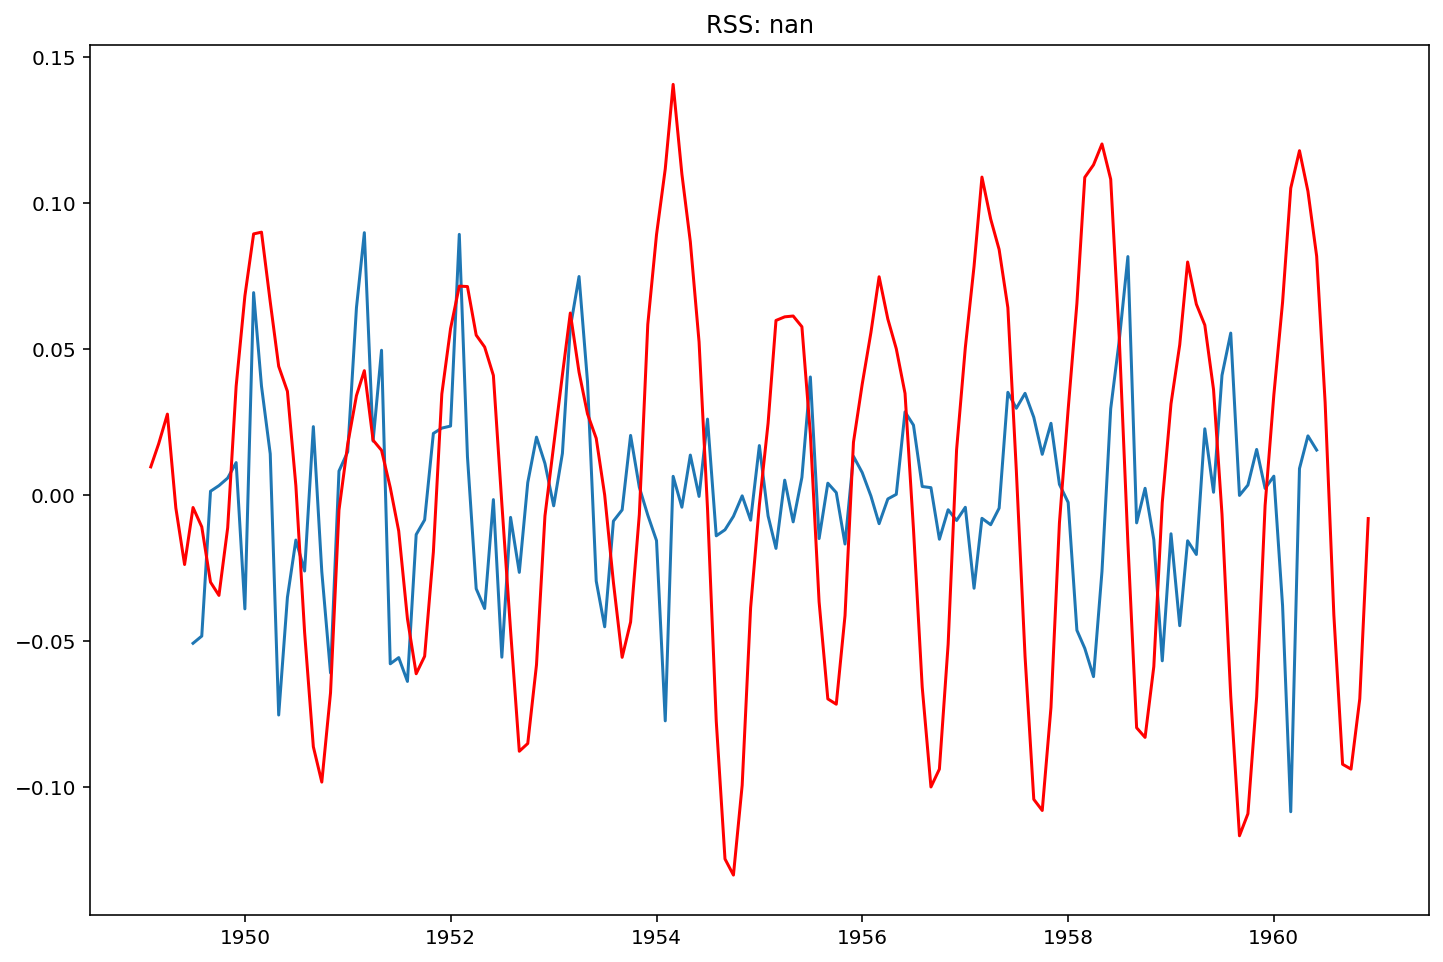

In [30]:
model = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(12, 8))
plt.plot(ts_log_decompose)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues-ts_log_decompose)**2))

In [31]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                 
=====================================================================================
Dep. Variable:     D.Thousands of Passengers   No. Observations:                  143
Model:                        ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                              css-mle   S.D. of innovations              0.084
Date:                       Wed, 01 Apr 2020   AIC                           -287.281
Time:                               12:40:51   BIC                           -269.504
Sample:                           02-01-1949   HQIC                          -280.057
                                - 12-01-1960                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.Thousands of Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.Thousands of Passengers    -0.8946      0.039    -23.127      0.000      -0.970      -0.819
ma.L1.D.Thousands of Passengers    -1.8270      0.036    -51.303      0.000      -1.897      -1.757
ma.L2.D.Thousands of Passengers     0.9245      0.036     25.568      0.000       0.854       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9106           -0.5372j            1.0573           -0.0848
AR.2            0.9106           +0.5372j            1.0573            0.0848
MA.1            0.9881           -0.3245j            1.0400           -0.0505
MA.2            0.9881           +0.3245j            1.0400            0.0505
-----------------------------------------------------------------------------
"""

C:\Users\utilisateur\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\utilisateur\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

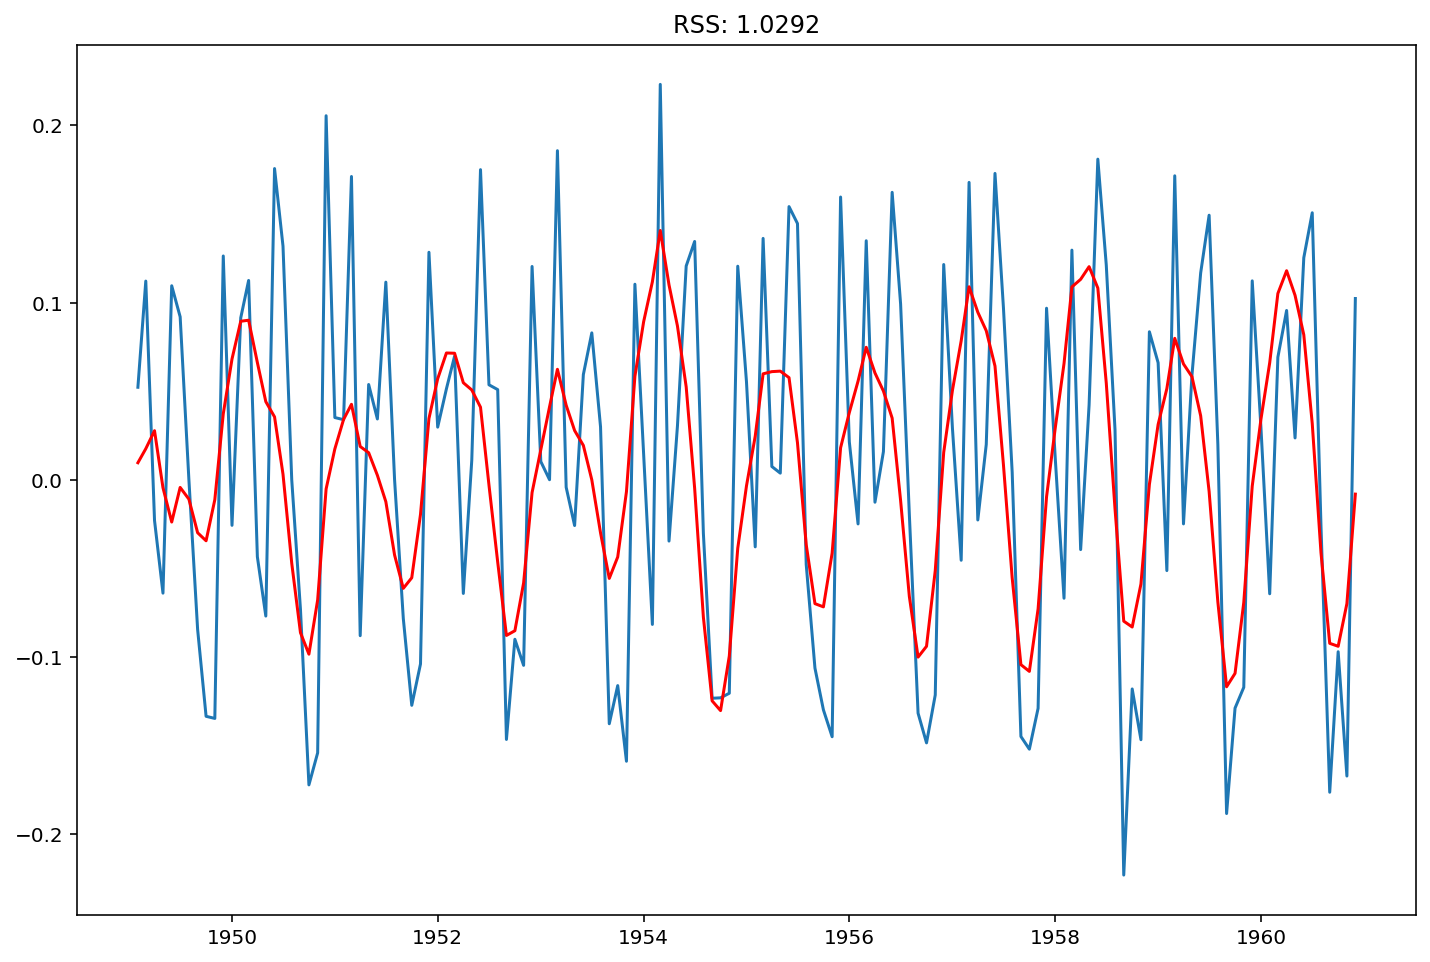

In [53]:
model = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(12, 8))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

C:\Users\utilisateur\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

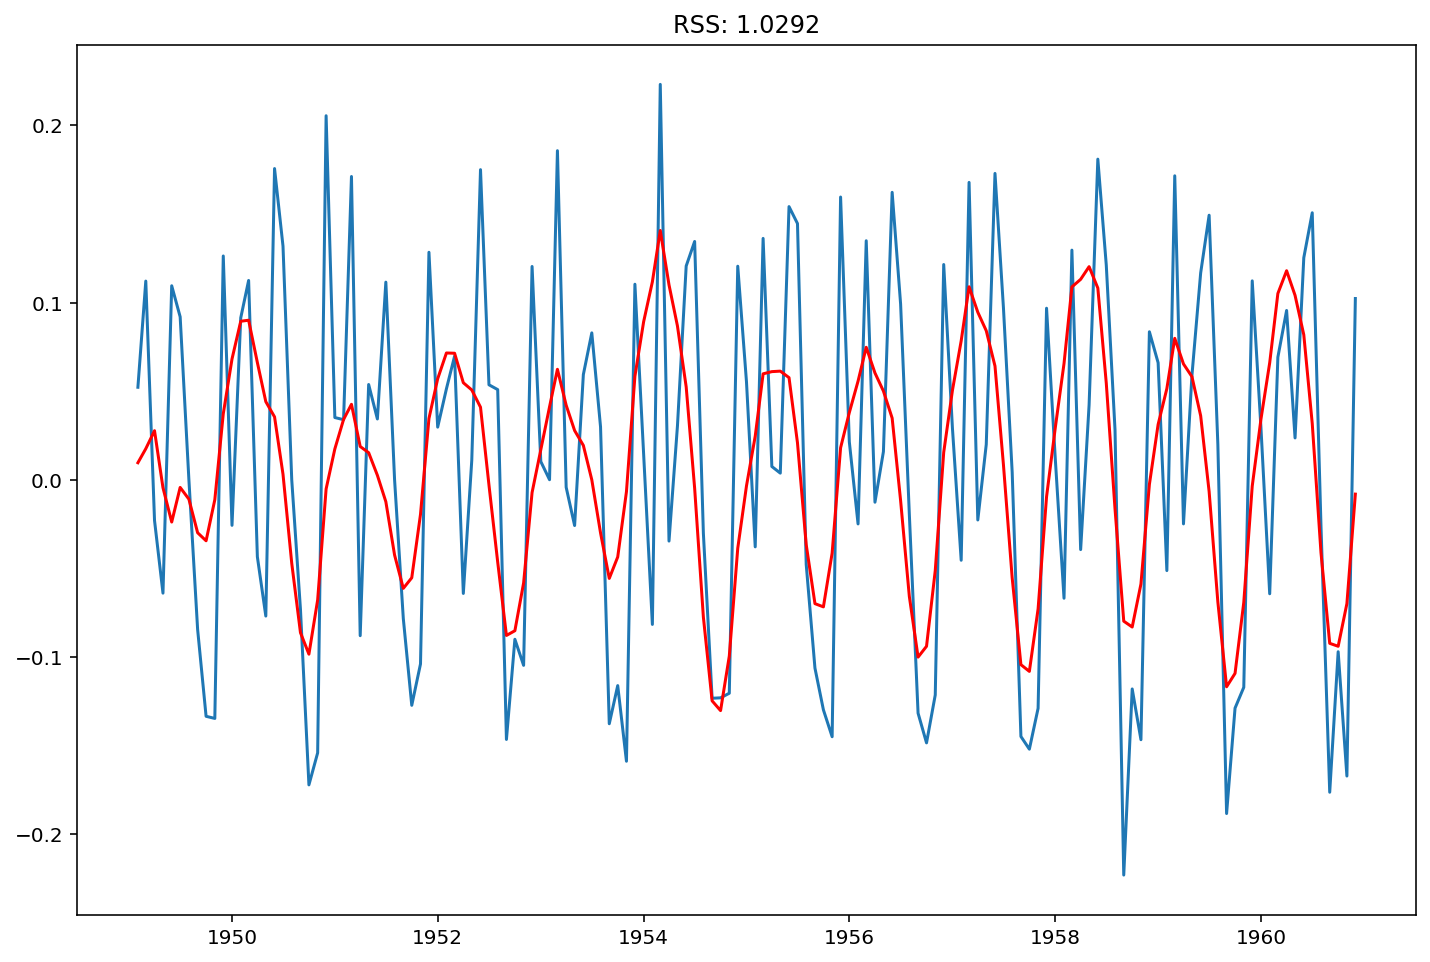

In [32]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_log_diff, order=(2,2))
results_ARMA = model.fit(disp=-1)
plt.figure(figsize=(12, 8))
plt.plot(ts_log_diff)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARMA.fittedvalues-ts_log_diff)**2))

RSS values:
- ARMA = 1.0292
- ARIMA = 1.0292

ARIMA and ARMA have the same RSS values.

FINAL STEP: BRINGING THIS BACK TO THE ORIGINAL 

Steps involved:
- First get the predicted values and store it as series. You will notice the first month is missing because we took a lag of 1(shift).
- Now convert differencing to log scale: find the cumulative sum and add it to a new series with a base value (here the first-month value of the log series).


# 6. Forecast et Prédictions

## Prediction ARIMA

In [33]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
                ...   
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
Length: 143, dtype: float64


In [34]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [35]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
print(predictions_ARIMA_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64


Next 
- Take the exponent of the series from above (anti-log) which will be the predicted value — the time series forecast model.

Now plot the predicted values with the original.
- Find the RMSE

Text(0.5, 1.0, 'RMSE: 90.1045')

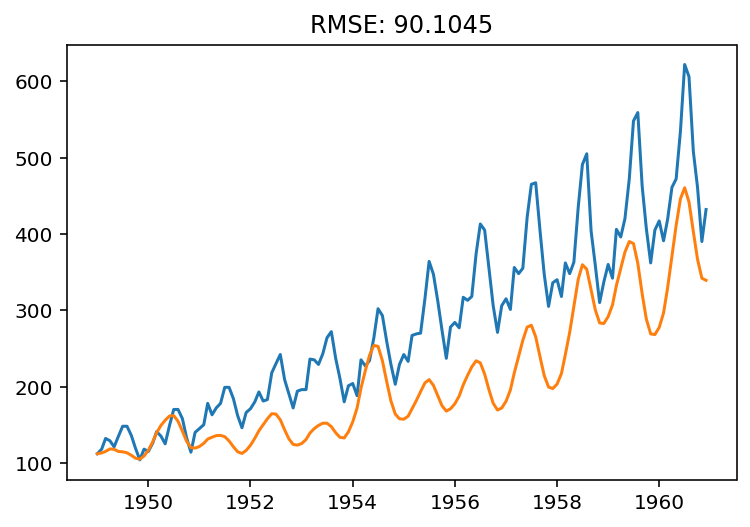

In [36]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f' % np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

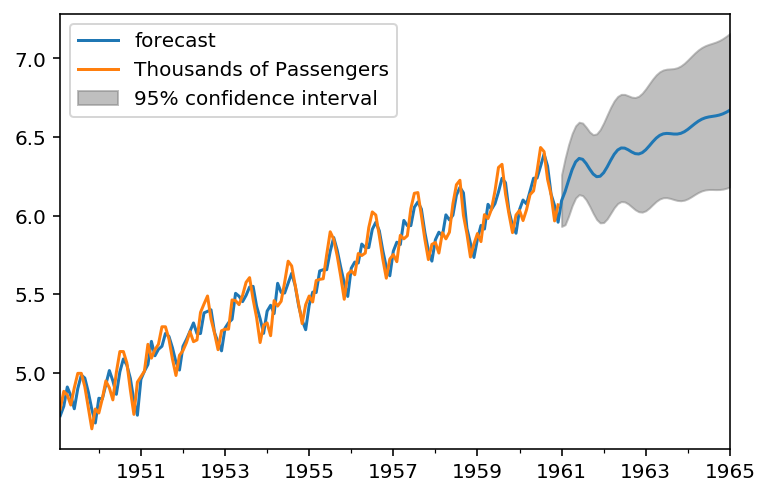

In [55]:
# 12 ans de données donc(12*12) + 4 ans de forecast (4*12) = 192
# start at 1 and end at 192.
fig = results_ARIMA.plot_predict(1,192)

## Prediction avec ARMA

In [37]:
predictions_ARMA_diff = pd.Series(results_ARMA.fittedvalues, copy=True)
print(predictions_ARMA_diff)

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
                ...   
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
Length: 143, dtype: float64


In [38]:
predictions_ARMA_diff_cumsum = predictions_ARMA_diff.cumsum()
print(predictions_ARMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [39]:
predictions_ARMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARMA_log = predictions_ARMA_log.add(predictions_ARMA_diff_cumsum, fill_value=0)
print(predictions_ARMA_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64


Text(0.5, 1.0, 'RMSE: 90.1045')

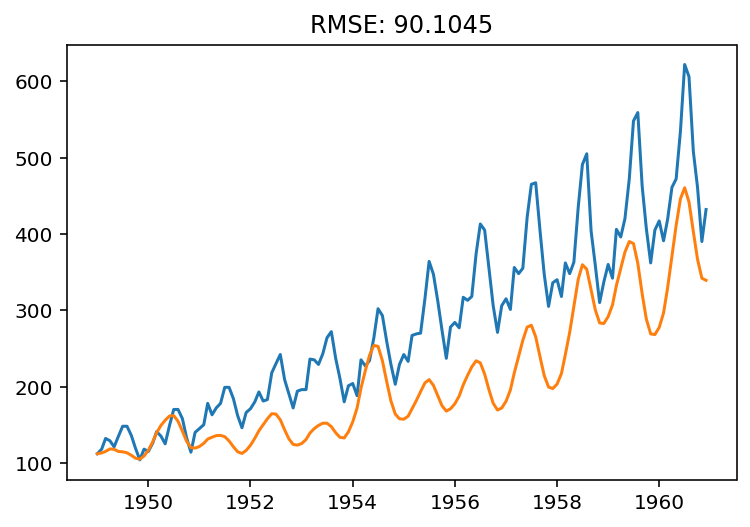

In [40]:
predictions_ARMA = np.exp(predictions_ARMA_log)
plt.plot(ts)
plt.plot(predictions_ARMA)
plt.title('RMSE: %.4f' % np.sqrt(sum((predictions_ARMA-ts)**2)/len(ts)))

## Forecast from the model fitted on the train dataset

Let's make a forecast 2 month ahead:

In [42]:
predictions_ARIMA_train = pd.Series(results_ARIMA_train.fittedvalues, copy=True)
print(predictions_ARIMA_train)

0      0.000050
1     -0.000725
2     -0.019357
3     -0.014462
4     -0.014567
         ...   
99    -0.006480
100   -0.012738
101    0.000301
102    0.002629
103    0.028931
Length: 104, dtype: float64


In [48]:
index = pd.DataFrame(test).index

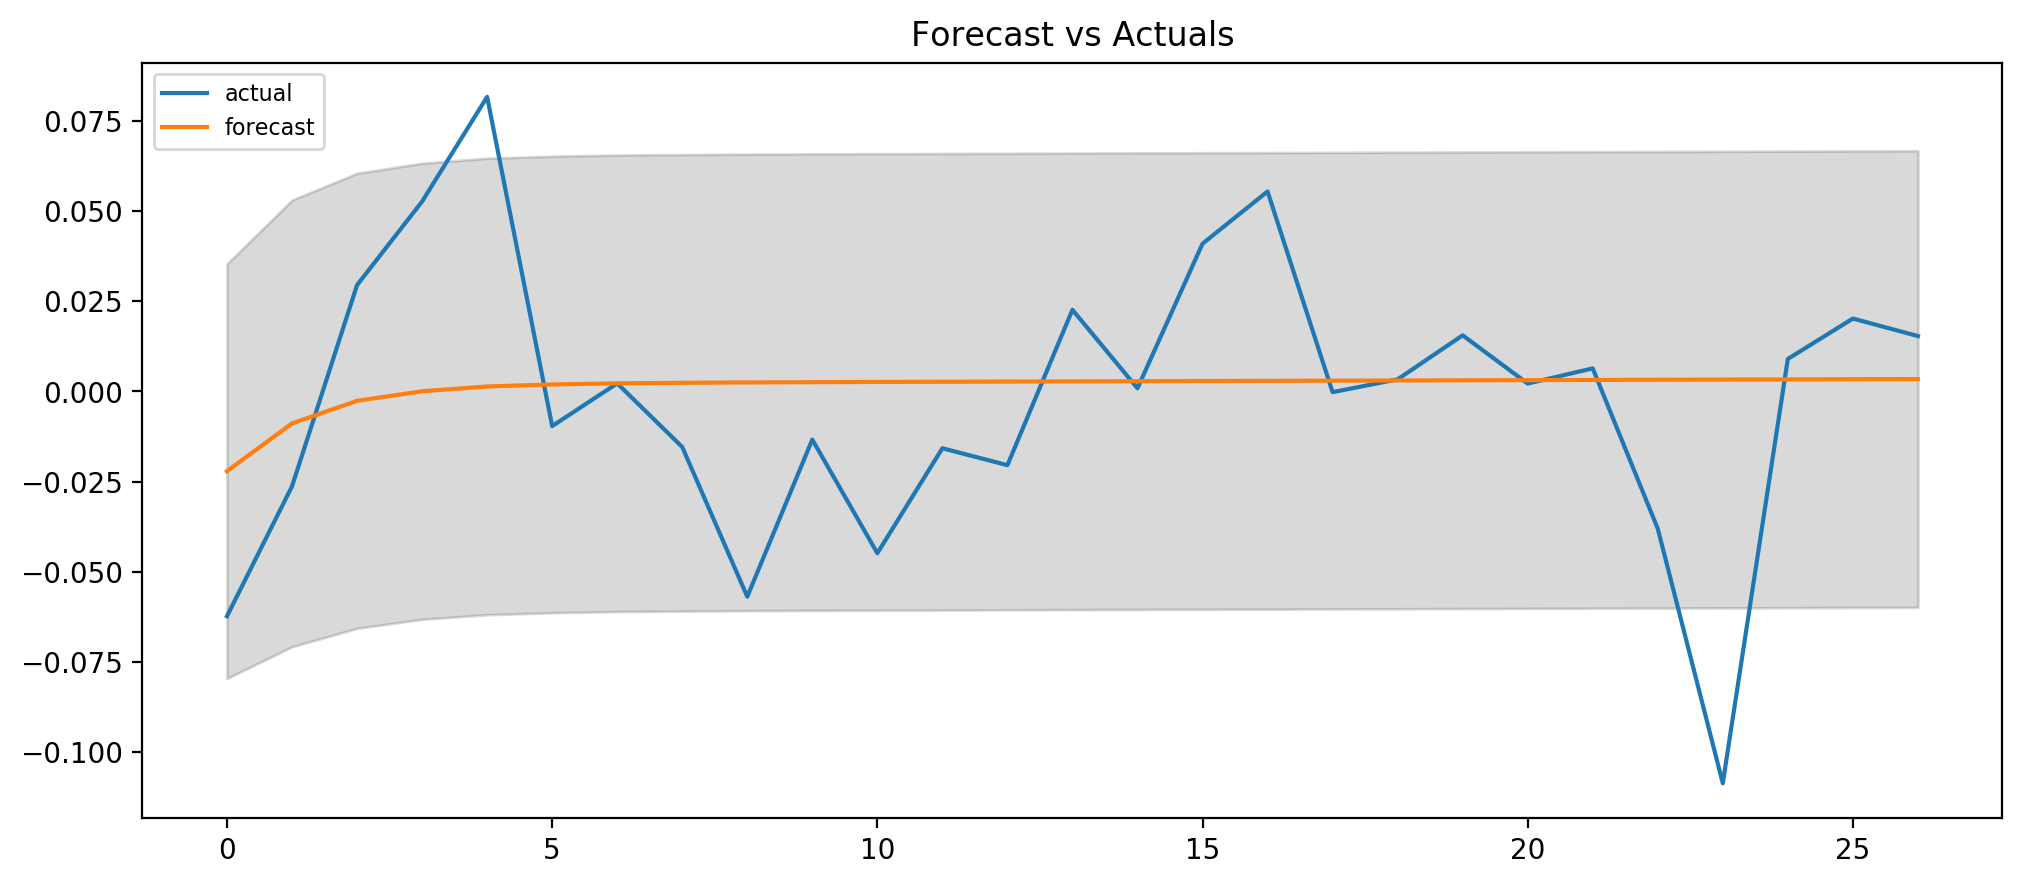

In [49]:
# Forecast
fc, se, conf = results_ARIMA_train.forecast(27, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=index)
#fc_series = fc_series + result.trend
#fc_series = fc_series + result.seasonal
#test = test + result.trend
#test = test + result.seasonal
lower_series = pd.Series(conf[:, 0], index=index)
upper_series = pd.Series(conf[:, 1], index=index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
test_df = pd.DataFrame(test)
fc = pd.DataFrame(fc_series)

In [62]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mae': mae, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc.values, test_df.values)

C:\Users\utilisateur\Anaconda3\envs\time_serie\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\utilisateur\Anaconda3\envs\time_serie\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\utilisateur\Anaconda3\envs\time_serie\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


{'mape': 1.4698276029601838,
 'mae': 0.027277821448175095,
 'rmse': 0.03800275649682611,
 'corr': nan,
 'minmax': 4.862005515492962}